In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

In [3]:
import xarray as xr
from scipy.interpolate import RectBivariateSpline, griddata

In [4]:
import utm

In [5]:
from stl import mesh  # install with `pip install numpy-stl`

In [6]:
import sys
sys.path.append('/home/rthedin/a2e-mmc')  # add path to your code location if needed
from mmctools.coupling.terrain import SRTM

# Terrain-Resolved Domain Setup
This notebook will generate a surface geometry file to be used by the microscale solver (e.g., SOWFA) to conform the solver domain to the terrain (e.g., with `moveDynamicMesh`).

Notebook written by Eliot Quon, modified by Regis Thedin
{eliot.quon,regis.thedin}@nrel.gov

## 1. User input

In [7]:
# Output directory (absolute dir)
outdir = '/home/rthedin/stl'

### 1.1 Mesoscale parameters

In [8]:
# Get lower resolution WRF terrain data
getWRFdata = False
# WRF reference solution to blend from low-res (WRF) at inflow boundaries to full SRTM resolution
wrfout = '/home/rthedin/MMC/WFIP2Region/20161121_YSU/wrfout_d01_2016-11-22_00:00:00'

### 1.2 Microscale parameters (from SOWFA setUp)

The `refloc` variable is the location coresponding to (0,0) in SOWFA.

Set the fringe on each side of the domain. This fringe region will used to blend the high-resolution SRTM domain data with either i) low-reosolution WRF (mesoscale) digital elevation model (DEM), or ii) flat.

If `getWRFdata` above is `True`, then blending to mesoscale will occur; otherwise, the domain will be blended to flat. If blending to flat, the user can specify an extra fringe region of completely flat domain (`fringe_flat`).

With respect to the bounding box, it is nice to have the boundaries exactly where the mesh would go because of the blending. For instance, a 5x5 km domain needs to match all the levels of cells: 20, 40, 80, 160 m. 5000/160 needs to be a round number, the same way 5000/80 needs be. However, we only really need to match the coarsest resolution because they are multiple. Also, remember to add 1m to each side, to avoid numerical issues on OpenFOAM.

In [85]:
# for TOTW. Fits both 20/40/80/160 and 30/60/120/240m grids (30m is the resolution from SRTM)
refloc = (42.944092, -105.773689, 500) # TOTW turbine 3032051 location
xmin,xmax = -25001, 5241
ymin,ymax = -7001,  13161
fringe_flat=100
fringe_s = 2000
fringe_n = 2000
fringe_w = 4000
fringe_e = 2000
case = f'totw_xm25001to5241_ym7001to13161_blendFlat2N2S2E4W_ff{fringe_flat}'

# for TOTW. Rimple's bounding box. Fits both 20/40/80/160 and 30/60/120/240m grids
refloc = (42.790035, -106.1757, 500) # TOTW turbine 3032051 location
xmin,xmax = -1, 49921
ymin,ymax = -1, 49921
fringe_flat=100
fringe_s = 3000
fringe_n = 3000
fringe_w = 3000
fringe_e = 3000
case = f'totw_xm1to49921_ym1to49921_blendFlat3N3S3E3W_ff{fringe_flat}'

# # For Biglow canyon
# refloc = (45.638004, -120.642973, 495) # biglow PS12 met mast
# xmin,xmax = -15001, 15721
# ymin,ymax = -5001, 15161
# fringe_flat=150
# fringe_w = 3000
# fringe_s = 3000
# fringe_n = 3000
# fringe_e = 3000
# case = f'biglow_xm15001to15721_ym5001to15161_blendFlat3N3S3E3W_ff{fringe_flat}'


In [65]:
ds = 10. # output resolution

## 2. Create output surface

In [44]:
x1 = np.arange(xmin, xmax+ds, ds)
y1 = np.arange(ymin, ymax+ds, ds)
xsurf,ysurf = np.meshgrid(x1, y1, indexing='ij')

## 3. Get the high-resolution terrain

In [58]:
# Terrain region to clip from the digital elevation model (DEM)
srtm_bounds = west, south, east, north = (refloc[1]-0.5, refloc[0]-0.4, refloc[1]+0.62, refloc[0]+0.42)

# this will be downloaded:
srtm_output=f'{outdir}/Physics_site_{case}.tif' # need absolute path for GDAL

In [59]:
srtm = SRTM(srtm_bounds, fpath=srtm_output, product='SRTM1')

In [60]:
%time srtm.download()
# CPU times: user 3.53 ms, sys: 12.7 ms, total: 16.2 ms
# Wall time: 8.74 s

CPU times: user 2.22 ms, sys: 39.9 ms, total: 42.1 ms
Wall time: 31.8 s


In [61]:
%%time
# original SRTM terrain stored as 'z'
x,y,z = srtm.to_terrain()

Output grid at ds= 30.0
EPSG code: 32613
CPU times: user 2.38 s, sys: 177 ms, total: 2.56 s
Wall time: 2.79 s


In [62]:
# get reference location to use as origin
xref,yref,_,_ = utm.from_latlon(*refloc[:2], force_zone_number=srtm.zone_number)

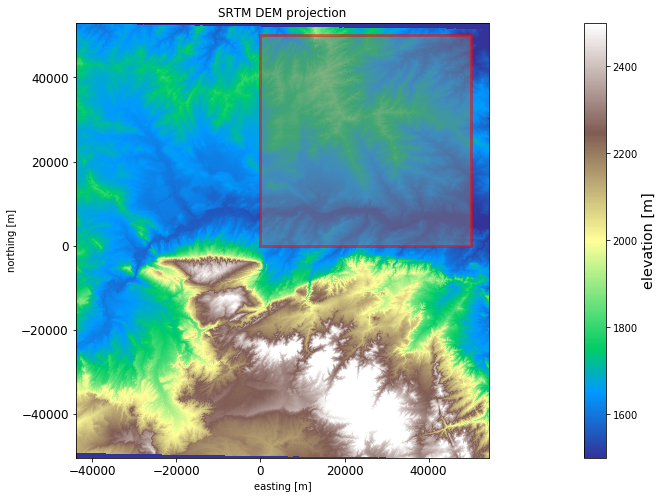

In [63]:
vmin,vmax = 1500,2500

fig,ax = plt.subplots(figsize=(12,8))
cm = ax.pcolormesh(x-xref, y-yref, z, cmap='terrain',vmin=vmin,vmax=vmax)
cb = fig.colorbar(cm,ax=ax)
cb.set_label('elevation [m]',fontsize='x-large')
ax.tick_params(labelsize='large')
ax.set_xlabel('easting [m]')
ax.set_ylabel('northing [m]')
ax.set_title('SRTM DEM projection')
ax.axis('scaled')

# bounding box for microscale region
les = Rectangle((xmin,ymin), xmax-xmin, ymax-ymin, edgecolor='r', lw=3, facecolor='0.5', alpha=0.5)
ax.add_patch(les)

### 3.1 Downscale to output grid

In [66]:
interpfun = RectBivariateSpline(x[:,0]-xref, y[0,:]-yref, z)

In [67]:
# resampled SRTM data stored in 'zsrtm'
zsrtm = interpfun(x1,y1,grid=True)

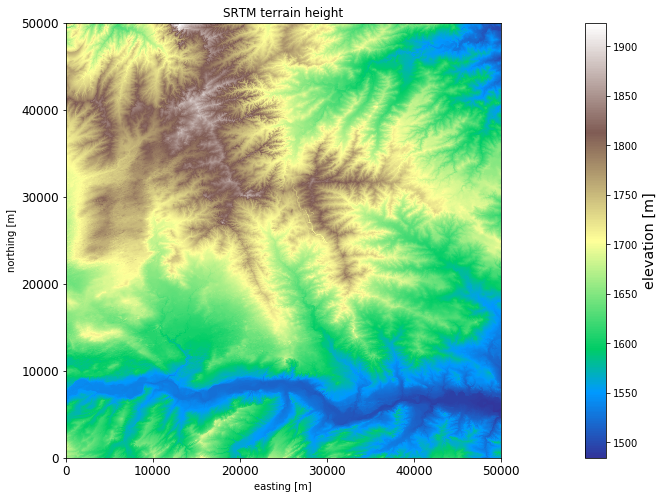

In [68]:
vmin,vmax = 1550,1850

fig,ax = plt.subplots(figsize=(12,8))
cm = ax.pcolormesh(xsurf, ysurf, zsrtm, cmap='terrain')#,vmin=vmin,vmax=vmax)
cb = fig.colorbar(cm,ax=ax)
cb.set_label('elevation [m]',fontsize='x-large')
ax.tick_params(labelsize='large')
ax.set_xlabel('easting [m]')
ax.set_ylabel('northing [m]')
ax.set_title('SRTM terrain height')
ax.axis('scaled')

fig.savefig(f'{outdir}/elevation_srtm_{case}.png',dpi=150,bbox_inches='tight')

## 4. Get the low-resolution terrain from the mesoscale
This part is only relevant if the user chose to blen the high-resolution SRTM terrain data with WRF

In [69]:
# Open the dataset
if getWRFdata is True:
    if os.path.exist(wrfout) is True:
        wrf = xr.open_dataset(wrfout)
        wrf['HGT']
    else:
        print('WRF input does not exist')
        sys.exit(1)

In [70]:
if getWRFdata is True:
    # wrf fields
    hgt = wrf['HGT'][0,:,:]
    xlat = wrf.coords['XLAT'][0,:,:]
    xlon = wrf.coords['XLONG'][0,:,:]

In [71]:
if getWRFdata is True:
    # %%time
    # # convert output cartesian grid to lat/lon - there's probably a more efficient way to do this
    # Npts = np.prod(xsurf.shape)
    # output_lat = np.empty(Npts)
    # output_lon = np.empty(Npts)
    # for ipt,(xi,yi) in enumerate(zip(xsurf.ravel()+xref, ysurf.ravel()+yref)):
    #     output_lat[ipt],output_lon[ipt] = utm.to_latlon(xi, yi,
    #                                                     zone_number=srtm.zone_number,
    #                                                     zone_letter=srtm.zone_letter)
    # # CPU times: user 2min 47s, sys: 173 ms, total: 2min 48s
    # # Wall time: 2min 48s

    %time output_lat, output_lon = srtm.to_latlon(xsurf.ravel()+xref, ysurf.ravel()+yref)

    # CPU times: user 3.38 s, sys: 157 ms, total: 3.54 s
    # Wall time: 3.54 s

In [72]:
if getWRFdata is True:
    %%time
    # interpolate to wrf surface elevation based on lat/lon (stored as 'zwrf')
    xi = np.stack((output_lat.ravel(),output_lon.ravel()),axis=-1)
    points = np.stack((xlat.values.ravel(),xlon.values.ravel()),axis=-1)
    values = hgt.values.ravel()
    zi = griddata(points,values,xi)
    zwrf = zi.reshape(xsurf.shape)
    # CPU times: user 3.14 s, sys: 931 ms, total: 4.07 s
    # Wall time: 2.57 s

In [73]:
if getWRFdata is True:
    fig,ax = plt.subplots(figsize=(12,8))
    cm = ax.pcolormesh(xsurf, ysurf, zwrf, cmap='viridis',vmin=vmin,vmax=vmax)
    cb = fig.colorbar(cm,ax=ax)
    cb.set_label('elevation [m]',fontsize='x-large')
    ax.tick_params(labelsize='large')
    ax.set_xlabel('easting [m]')
    ax.set_ylabel('northing [m]')
    ax.set_title('WRF terrain height')
    ax.axis('scaled')

    fig.savefig(f'elevation_wrf_{os.path.basename(wrfout)}.png',dpi=150,bbox_inches='tight')

## 5. Blend surface definitions

In [74]:
# check distance from west boundary
blend_w = np.ones(xsurf.shape)
if fringe_w > 0:
    blend_w = np.minimum(np.maximum((xsurf-xmin-fringe_flat)/fringe_w, 0), 1)

In [75]:
# check distance from east boundary
blend_e = np.ones(xsurf.shape)
if fringe_e > 0:
    blend_e = np.minimum(np.maximum((xmax-xsurf-fringe_flat)/fringe_e, 0), 1)

In [76]:
# check distance from south boundary
blend_s = np.ones(xsurf.shape)
if fringe_s > 0:
    blend_s = np.minimum(np.maximum((ysurf-ymin-fringe_flat)/fringe_s, 0), 1)

In [77]:
# check distance from north boundary
blend_n = np.ones(xsurf.shape)
if fringe_n > 0:
    blend_n = np.minimum(np.maximum((ymax-ysurf-fringe_flat)/fringe_n, 0), 1)

In [78]:
# combine blending functions
blend = blend_w * blend_e * blend_s * blend_n

(0.0, 50000.0, 0.0, 50000.0)

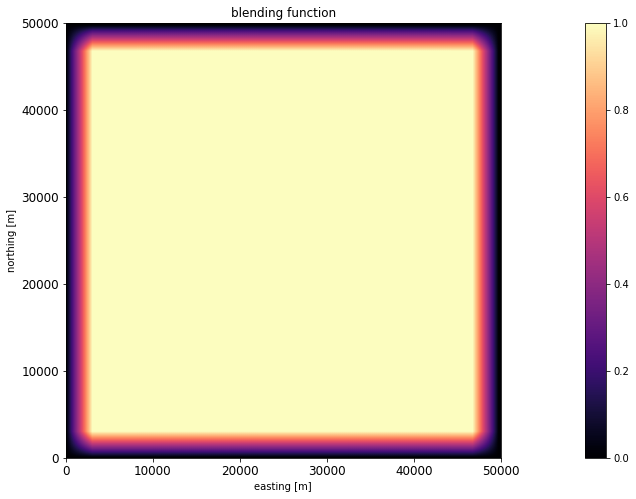

In [79]:
fig,ax = plt.subplots(figsize=(12,8))
cm = ax.pcolormesh(xsurf, ysurf, blend, cmap='magma')
cb = fig.colorbar(cm,ax=ax)
ax.tick_params(labelsize='large')
ax.set_xlabel('easting [m]')
ax.set_ylabel('northing [m]')
ax.set_title('blending function')
ax.axis('scaled')

In [80]:
# create flat surface to be blended
# SRTM data is unlikely to be around the z=0 mark, so get the average 
z0 = np.mean(zsrtm)
zflat = np.full(zsrtm.shape,z0)

In [81]:
# surface to blend
if getWRFdata is True:
    zlowres = zwrf
else:
    zlowres = zflat

In [82]:
# now, blend the high/low resolution elevations
zblend = blend*zsrtm + (1-blend)*zlowres

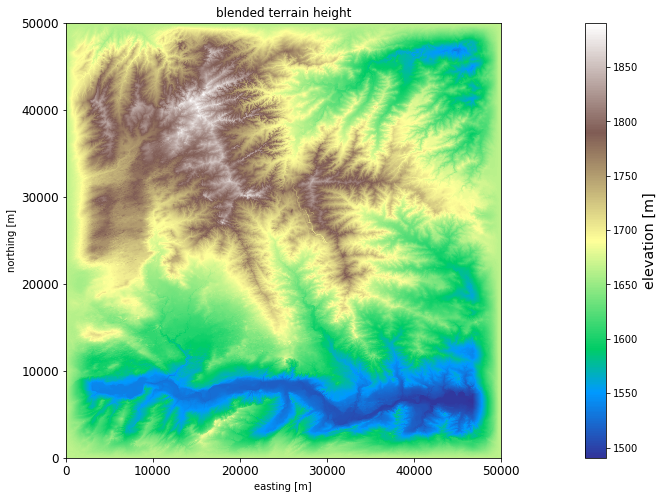

In [83]:
fig,ax = plt.subplots(figsize=(12,8))
cm = ax.pcolormesh(xsurf, ysurf, zblend, cmap='terrain')#,vmin=vmin,vmax=vmax)
cb = fig.colorbar(cm,ax=ax)
cb.set_label('elevation [m]',fontsize='x-large')
ax.tick_params(labelsize='large')
ax.set_xlabel('easting [m]')
ax.set_ylabel('northing [m]')
ax.set_title('blended terrain height')
ax.axis('scaled')
fig.savefig(f'{outdir}/elevation_blended_{case}.png',dpi=150,bbox_inches='tight')

## 6. Write out terrain surface STL

In [86]:
stlout = f'{outdir}/{case}.stl'

In [87]:
# output 'zblend' surface - can skip blending step and just output 'zsrtm'
Npts = np.prod(xsurf.shape)
stlpoints = np.stack((xsurf.ravel(),
                      ysurf.ravel(),
                     zblend.ravel()),  # <-- output surface here
                    axis=-1)

stlindices = np.reshape(np.arange(Npts), xsurf.shape)

In [88]:
%%time
Nx,Ny = xsurf.shape
Nfaces = (Nx-1)*(Ny-1)*2

surf = mesh.Mesh(np.zeros(Nfaces, dtype=mesh.Mesh.dtype))

#
# manually define triangular faces for this simple quad mesh
#
# for iface, f in enumerate(faces):
#     for dim in range(3):
#         surf.vectors[iface][dim] = vertices[f[dim],:]
iface = 0 
for i in range(Nx-1):
    for j in range(Ny-1):
        surf.vectors[iface,0,:] = stlpoints[stlindices[i,j],:]
        surf.vectors[iface,1,:] = stlpoints[stlindices[i+1,j],:]
        surf.vectors[iface,2,:] = stlpoints[stlindices[i+1,j+1],:]
        surf.vectors[iface+1,0,:] = stlpoints[stlindices[i+1,j+1],:]
        surf.vectors[iface+1,1,:] = stlpoints[stlindices[i,j+1],:]
        surf.vectors[iface+1,2,:] = stlpoints[stlindices[i,j],:]
        iface += 2
assert (iface == Nfaces)
# CPU times: user 27.5 s, sys: 182 ms, total: 27.7 s
# Wall time: 27.7 s

CPU times: user 3min 6s, sys: 1.06 s, total: 3min 8s
Wall time: 3min 9s


In [89]:
dpath = os.path.dirname(stlout)
if (not dpath == '') and (not os.path.isdir(dpath)):
    os.makedirs(dpath)
    print('Created',dpath)
    
surf.save(stlout)
print('Saved',stlout)

Saved /home/rthedin/stl/totw_xm1to49921_ym1to49921_blendFlat3N3S3E3W_ff100.0.stl
